In [1]:
import json
from rdflib import Graph, Literal, BNode, Namespace, RDF, URIRef
import holoviews as hv
import networkx as nx

### Graph Creation

In [2]:
g = Graph()

def create_rdf_graph(data):
    ARXIV = Namespace("http://arxiv.org/")

    # Create a URI for this paper
    paper = URIRef(ARXIV + data['paper_id'])

    # Add triples using store's add method.
    g.add((paper, RDF.type, ARXIV.Paper))
    g.add((paper, ARXIV.title, Literal(data['metadata']['title'])))
    g.add((paper, ARXIV.discipline, Literal(data['discipline'])))
    g.add((paper, ARXIV.abstract, Literal(data['abstract']['text'])))
    g.add((paper, ARXIV.Author, Literal(data['metadata']['authors'])))

    # Iterating over body_text (assuming it's a list of dictionaries)
    for section in data['body_text']:
        if 'text' in section:
            g.add((paper, ARXIV.body, Literal(section['text'])))

    # Iterating over bib_entries (assuming it's a dictionary)
    for id, bib_entry in data['bib_entries'].items():
        bib_entry_bnode = BNode()
        g.add((bib_entry_bnode, RDF.type, ARXIV.BibEntry))
        g.add((bib_entry_bnode, ARXIV.bib_entry_raw, Literal(bib_entry['bib_entry_raw'])))
        # Adding contained_arXiv_ids if they exist
        if 'contained_arXiv_ids' in bib_entry:
            for arxiv_id in bib_entry['contained_arXiv_ids']:
                linked_paper = URIRef(ARXIV + arxiv_id['id'])
                g.add((bib_entry_bnode, ARXIV.contained_arXiv_id, linked_paper))
                g.add((paper, ARXIV.cites, linked_paper))
                g.add((bib_entry_bnode, ARXIV.contained_arXiv_text, Literal(arxiv_id['text'])))

    # Iterating over ref_entries (assuming it's a dictionary)
    for id, ref_entry in data['ref_entries'].items():
        ref_entry_bnode = BNode()
        g.add((ref_entry_bnode, RDF.type, ARXIV.RefEntry))
        g.add((ref_entry_bnode, ARXIV.ref_type, Literal(ref_entry['type'])))
        # Adding caption or latex depending on the type of ref_entry
        if 'caption' in ref_entry and ref_entry['type'] == 'figure':
            g.add((ref_entry_bnode, ARXIV.captionfigure, Literal(ref_entry['caption'])))
        elif 'caption' in ref_entry and ref_entry['type'] == 'table':
            g.add((ref_entry_bnode, ARXIV.captiontable, Literal(ref_entry['caption'])))

# Open your jsonl file
with open('dataset.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        create_rdf_graph(data)

### Save the graph to use it in other files

In [3]:
import pickle
with open('graph.pkl', 'wb') as f:
    pickle.dump(g, f)

### Visualization of the subgraphs obtained using SPARQL querying

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
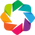

In [4]:
hv.extension('bokeh')

# Convert SPARQL results to networkx graph
def sparql_to_networkx_graph(results):
    G = nx.Graph()
    for row in results:
        G.add_edge(str(row[0]), str(row[1]))
    return G

# Convert networkx graph to holoviews graph
def networkx_to_holoviews_graph(G):
    hv_graph = hv.Graph.from_networkx(G, nx.layout.spring_layout)
    return hv_graph

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
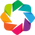

:Graph   [start,end]

In [5]:
# Define the SPARQL query
query = """
    SELECT ?subject ?predicate ?object
    WHERE {
        ?subject ?predicate ?object .
    }
    LIMIT 500
"""

# Execute the query
sub = g.query(query)

hv.extension('bokeh')

# Convert SPARQL results to networkx graph
def sparql_to_networkx_graph(results):
    G = nx.Graph()
    for row in results:
        G.add_edge(str(row[0]), str(row[1]))
    return G

# Convert networkx graph to holoviews graph
def networkx_to_holoviews_graph(G):
    hv_graph = hv.Graph.from_networkx(G, nx.layout.spring_layout)
    return hv_graph

# Graphs for subgraph1
G1 = sparql_to_networkx_graph(sub)
hv_g1 = networkx_to_holoviews_graph(G1)

# Plot with holoviews
hv_g1.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)


In [6]:
# Query to provide valuable insights on the number and titles of papers in the "Computer Science" discipline. 

q1 = '''
    PREFIX ARXIV: <http://arxiv.org/>
    SELECT ?paper ?title
    WHERE {
        ?paper a ARXIV:Paper ;
               ARXIV:title ?title ;
               ARXIV:discipline "Statistics" .
    }
'''

# Perform the query on the graph
subgraph1 = g.query(q1)

# Graphs for subgraph1
G1 = sparql_to_networkx_graph(subgraph1)
hv_g1 = networkx_to_holoviews_graph(G1)

# Plot with holoviews
hv_g1.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)


:Graph   [start,end]

In [7]:
# Query to Find all papers on a specific topic.
# This could be useful for a researcher looking to find all papers on a specific topic, e.g., "differential privacy".

q2 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT ?paper ?title 
WHERE {
  ?paper a arxiv:Paper.
  ?paper arxiv:title ?title.
  FILTER (CONTAINS(?title, "Quantum"))
}
'''

# Perform the query on the graph
subgraph2 = g.query(q2)

# Graphs for subgraph2
G2 = sparql_to_networkx_graph(subgraph2)
hv_g2 = networkx_to_holoviews_graph(G2)

# Plot with holoviews
hv_g2.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [8]:
# Query to Retrieve all papers written by a particular author.
# This can be beneficial for someone who wants to explore all papers published by a certain author, e.g., "Sansit Patnaik".

q3 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT ?paper ?title
WHERE {
  ?paper a arxiv:Paper.
  ?paper arxiv:Author ?author.
  ?paper arxiv:title ?title.
  FILTER (CONTAINS(?author, "Sansit Patnaik"))
}

'''

# Perform the query on the graph
subgraph3 = g.query(q3)

# Graphs for subgraph3
G3 = sparql_to_networkx_graph(subgraph3)
hv_g3 = networkx_to_holoviews_graph(G3)

# Plot with holoviews
hv_g3.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [9]:
# Query to Find all papers citing a specific paper.
# This could be helpful for a researcher trying to gauge the impact of a specific work, e.g., a paper with citeID "1807.06209"

q4 = '''
PREFIX arxiv: <http://arxiv.org/>

SELECT DISTINCT ?paper ?title
WHERE {
  ?paper a arxiv:Paper.
  ?paper arxiv:title ?title.
  ?paper arxiv:cites ?linked.
  FILTER (?linked = <http://arxiv.org/1807.06209>)
}
'''

# Perform the query on the graph
subgraph4 = g.query(q4)

# Graphs for subgraph4
G4 = sparql_to_networkx_graph(subgraph4)
hv_g4 = networkx_to_holoviews_graph(G4)

# Plot with holoviews
hv_g4.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [10]:
# Query to give insights into the papers that discuss a specific topic or concept ("ML" in this case).

q5 = '''
    PREFIX ARXIV: <http://arxiv.org/>
    SELECT ?paper ?title
    WHERE {
        ?paper a ARXIV:Paper ;
               ARXIV:title ?title ;
               ARXIV:abstract ?abstract .
        FILTER(contains(?abstract, "ML"))
    }
'''

# Perform the query on the graph
subgraph5 = g.query(q5)

# Graphs for subgraph4
G5 = sparql_to_networkx_graph(subgraph5)
hv_g5 = networkx_to_holoviews_graph(G5)

# Plot with holoviews
hv_g5.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)

:Graph   [start,end]

In [11]:
# Query to get all citations in the knowledge graph

q6 = """
    SELECT ?paper ?cited_paper WHERE {
        ?paper <http://arxiv.org/cites> ?cited_paper.
    }
"""

# for citation in citations:
#     print(f'Paper {citation[0]} cites {citation[1]}')

# Perform the query on the graph
subgraph6 = g.query(q6)

# Graphs for subgraph4
G6 = sparql_to_networkx_graph(subgraph6)
hv_g6 = networkx_to_holoviews_graph(G6)

# Plot with holoviews
hv_g6.opts(padding=0.1, width=400, height=400, xaxis=None, yaxis=None)


:Graph   [start,end]